# Nhận diện gương mặt với khẩu trang

# 1. Sơ lược dự án

Một trong những ứng dụng phổ biến của Máy học là **Nhận diện gương mặt**. Ứng dụng này có mặt hầu như ở mọi mặt trong đời sống xã hội cũng như khoa học công nghệ, chúng ta sử dụng nhận diện gương mặt để chấm công nhân viên, sử dụng nhận diện gương mặt cho mục đích an ninh, ... Ở dự án này, chúng ta cũng sẽ tiến hành tạo ra một mô hình nâng cao hơn. Vẫn là mô hình **nhận diện gương mặt**, nhưng lần này chúng ta sẽ tiến hành thêm một bước sau khi đã nhận diện được một gương mặt từ tấm ảnh hay video, đó là xem thử liệu một khuôn mặt **có đeo khẩu trang hay không**. Việc này có ứng dụng rất lớn trong bối cảnh dịch bệnh Covid hiện nay, tiến hành phát hiện sớm một người không đeo khẩu trang có thể giảm thiểu mức độ lây nhiễm xuống thấp, qua đó góp phần thúc đẩy việc đẩy lùi dịch bệnh một cách nhanh chóng và ít tốn kém hơn. Tức là mô hình của chúng ta sẽ hoạt động như sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trăng hoặc không (3) --> Gán nhãn tương ứng (4)**

Chúng ta sẽ tạo ra mô hình ở **bước (3)** và sử dụng các mô hình nhận diện gương mặt có sẵn để tạo thành một pipeline hoàn chỉnh ở trên

Cụ thể, trong dự án này chúng ta sẽ thực hiện các bước sau:

1. Tạo ra một tập dữ liệu (bao gồm các gương mặt có và không có đeo khẩu trang) từ nhiều nguồn khác nhau.
2. Tiền xử lý dữ liệu
3. Chia tập dữ liệu dùng riêng cho mục đích huấn luyện và kiểm tra mô hình
4. Huấn luyện mô hình
5. Kiểm tra mô hình
6. Cải tiến

- Vẫn như các dự án máy học khác, điều đầu tiên chúng ta cần làm là import các thư viện cần thiết

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths
import cv2
from PIL import Image

import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 2. Khởi tạo tập dữ liệu

Lần này, dữ liệu sẽ không được cung cấp sẵn, bạn sẽ phải tự tạo ra một tập dữ liệu từ nhiều nguồn có sẵn và ghép chúng lại thành một tập dữ liệu duy nhất cho dự án này. 

1. Đầu tiên, bạn phải download các tập dữ liệu từ các nguồn sau đây

    - https://www.kaggle.com/andrewmvd/face-mask-detection
	- https://www.kaggle.com/omkargurav/face-mask-dataset
	- https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset
	- https://www.kaggle.com/vijaykumar1799/face-mask-detection
	- https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset
	- https://www.kaggle.com/spandanpatnaik09/face-mask-detectormask-not-mask-incorrect-mask
	- https://www.kaggle.com/sumansid/facemask-dataset
	- https://drive.google.com/file/d/1m6Rd5nxol_cT2EKHSodli9HD1L6k0bKR/view
    
Bạn có thể thấy, các tập dữ liệu đã được chia nhỏ thành 2 thư mục riêng biệt, đó là **có đeo khẩu trang (with mask)** và **không đeo khẩu trang (without mask)**. Chúng có thể được chứa trong các thư mục lớn hơn nữa là train, validation và test; nhưng điều này không đáng kể, bạn chỉ cần lưu ý 2 thư mục đã nêu ở trên.

2. Bạn đem các ảnh tải được bỏ vào trong thư mục **dataset** theo cấu trúc sau:

```
dataset <- thư mục chứa ảnh dữ liệu cho dự án
└───with mask <- ảnh của các khuôn mặt có đeo khẩu trang được chứa trong thư mục này
│       1.jpg
│       ...
└───without mask <- ảnh của các khuôn mặt không có đeo khẩu trang được chứa trong thư mục này
│       2.jpg
│       ...         
```

**Lưu ý:** Có thể sẽ có một vài tấm ảnh bị trùng giữa các nguồn dữ liệu khác nhau, bạn chỉ cần bỏ qua quá trình sao chép các tấm ảnh bị trùng này vào tập **dataset** là được.

## Download Dataset from Kaggle using `Kaggle API`

Download `gdown` module in order to download files from `google drive`

In [2]:
!pip install --upgrade --no-cache-dir gdown

`gdown` will download MY `kaggle.json` file in the [link](https://drive.google.com/file/d/1-if_p-hShaCuhf2rrWqB7d8asZAGBcYs/view?usp=sharing) below

In [3]:
!gdown https://drive.google.com/file/d/1-if_p-hShaCuhf2rrWqB7d8asZAGBcYs/view?usp=sharing --fuzzy 

Downloading...
From: https://drive.google.com/uc?id=1-if_p-hShaCuhf2rrWqB7d8asZAGBcYs
To: C:\Users\Acer\Downloads\EXPERIMENT\problem\kaggle.json

  0%|          | 0.00/69.0 [00:00<?, ?B/s]
100%|##########| 69.0/69.0 [00:00<?, ?B/s]


Once downloaded `kaggle.json`, we have to put it in the requested directory. (You willl get notification show you the path to put in).

In my computer, is is `C:\Users\Acer\.kaggle`.

In [4]:
!copy kaggle.json C:\Users\Acer\.kaggle

        1 file(s) copied.


Download `Kaggle API` in order to download Kaggle Datasets

In [5]:
!pip install kaggle

**Note**: 
* Here we have 8 links correspond to 8 Datasets
* All of Datasets will be downloaded under the format: `x_data`, where x is a number

## 1st Dataset

First, we need to prepare the `dataset` folder with `subdirectories` are `with mask` and `without mask`

In [7]:
###### LINUX ######
# !mkdir -p dataset/{with\ mask,without\ mask} # {with\ mask,without\ mask} => no space between ','

### WDS ###
!md "dataset\with mask" "dataset\without mask"

A subdirectory or file dataset\with mask already exists.
Error occurred while processing: dataset\with mask.
A subdirectory or file dataset\without mask already exists.
Error occurred while processing: dataset\without mask.


In [8]:
# to remove the 'dataset' directory RECURSIVELY
### LINUX ###
# !rm -r dataset

### WINDOWS ###
# !rmdir /s /q dataset 

In [9]:
# a function to discover through the dataset
def walk_through_dir(name):
    for dirpath, dirnames, filenames in os.walk(name):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

Now download the dataset from Kaggle using `Kaggle API`

In [10]:
!kaggle datasets download -h # get help message

usage: kaggle datasets download [-h] [-f FILE_NAME] [-p PATH] [-w] [--unzip]
                                [-o] [-q]
                                [dataset]

optional arguments:
  -h, --help            show this help message and exit
  dataset               Dataset URL suffix in format <owner>/<dataset-name> (use "kaggle datasets list" to show options)
  -f FILE_NAME, --file FILE_NAME
                        File name, all files downloaded if not provided
                        (use "kaggle datasets files -d <dataset>" to show options)
  -p PATH, --path PATH  Folder where file(s) will be downloaded, defaults to current working directory
  -w, --wp              Download files to current working path
  --unzip               Unzip the downloaded file. Will delete the zip file when completed.
  -o, --force           Skip check whether local version of file is up to date, force file download
  -q, --quiet           Suppress printing information about the upload/download progress


In [ ]:
# download Kaggle Dataset with id:omkargurav/face-mask-dataset
!kaggle datasets download omkargurav/face-mask-dataset --unzip 

The folder was downloaded under the name `data`

In [15]:
# Rename the data -> 1_data

## LINUX ##
#!mv data 1_data 

# WINDOWS #
!ren data 1_data

The system cannot find the file specified.


In [16]:
walk_through_dir('1_data')

There are 2 directories and 0 images in '1_data'.
There are 0 directories and 3828 images in '1_data\without_mask'.
There are 0 directories and 3725 images in '1_data\with_mask'.


Copy all images to `dataset` folder

In [ ]:
### LINUX ###
# !cp -a 1_data/with_mask/. dataset/with\ mask/
# !cp -a 1_data/without_mask/. dataset/without\ mask/

### WINDS ###
!copy "1_data\with_mask"\* "dataset\with mask"
!copy "1_data\without_mask"\* "dataset\without mask"

In [18]:
walk_through_dir('dataset')

There are 2 directories and 0 images in 'dataset'.
There are 0 directories and 3725 images in 'dataset\with mask'.
There are 0 directories and 3828 images in 'dataset\without mask'.


## 2nd Dataset

In [ ]:
!kaggle datasets download prithwirajmitra/covid-face-mask-detection-dataset --unzip

In [20]:
# !mv New\ Masks\ Dataset 2_data #LINUX

# Windows
!ren "New Masks Dataset" 2_data

In [21]:
walk_through_dir('2_data')

There are 3 directories and 0 images in '2_data'.
There are 2 directories and 0 images in '2_data\Test'.
There are 0 directories and 50 images in '2_data\Test\Mask'.
There are 0 directories and 50 images in '2_data\Test\Non Mask'.
There are 2 directories and 0 images in '2_data\Train'.
There are 0 directories and 300 images in '2_data\Train\Mask'.
There are 0 directories and 300 images in '2_data\Train\Non Mask'.
There are 2 directories and 0 images in '2_data\Validation'.
There are 0 directories and 153 images in '2_data\Validation\Mask'.
There are 0 directories and 153 images in '2_data\Validation\Non Mask'.


In [ ]:
folders = ["Train", "Validation", "Test"]

for folder in folders:
    without_mask_path = os.path.join("2_data", folder, "Non Mask") 
    with_mask_path = os.path.join("2_data", folder, "Mask")

    !echo {without_mask_path}
    !echo {with_mask_path}

    !copy "{without_mask_path}\*" "dataset\without mask"
    !copy "{with_mask_path}\*" "dataset\with mask"

In [23]:
walk_through_dir('dataset')

There are 2 directories and 0 images in 'dataset'.
There are 0 directories and 4228 images in 'dataset\with mask'.
There are 0 directories and 4331 images in 'dataset\without mask'.


## 3rd Dataset

Here we add `-p` flag to pass the `path` of folder storing our downloaded data - which is `3_data`

In [ ]:
!kaggle datasets download vijaykumar1799/face-mask-detection --unzip -p 3_data 

In [25]:
walk_through_dir('3_data')

There are 1 directories and 0 images in '3_data'.
There are 3 directories and 0 images in '3_data\Dataset'.
There are 0 directories and 2994 images in '3_data\Dataset\mask_weared_incorrect'.
There are 0 directories and 2994 images in '3_data\Dataset\without_mask'.
There are 0 directories and 2994 images in '3_data\Dataset\with_mask'.


In [ ]:
!copy "3_data\Dataset\with_mask"\* "dataset\with mask"
!copy "3_data\Dataset\without_mask"\* "dataset\without mask"

In [27]:
walk_through_dir('dataset')

There are 2 directories and 0 images in 'dataset'.
There are 0 directories and 7079 images in 'dataset\with mask'.
There are 0 directories and 7325 images in 'dataset\without mask'.


## 4th Dataset

In [ ]:
!kaggle datasets download ashishjangra27/face-mask-12k-images-dataset --unzip -p 4_data

In [29]:
walk_through_dir('4_data')

There are 1 directories and 0 images in '4_data'.
There are 3 directories and 0 images in '4_data\Face Mask Dataset'.
There are 2 directories and 0 images in '4_data\Face Mask Dataset\Test'.
There are 0 directories and 483 images in '4_data\Face Mask Dataset\Test\WithMask'.
There are 0 directories and 509 images in '4_data\Face Mask Dataset\Test\WithoutMask'.
There are 2 directories and 0 images in '4_data\Face Mask Dataset\Train'.
There are 0 directories and 5000 images in '4_data\Face Mask Dataset\Train\WithMask'.
There are 0 directories and 5000 images in '4_data\Face Mask Dataset\Train\WithoutMask'.
There are 2 directories and 0 images in '4_data\Face Mask Dataset\Validation'.
There are 0 directories and 400 images in '4_data\Face Mask Dataset\Validation\WithMask'.
There are 0 directories and 400 images in '4_data\Face Mask Dataset\Validation\WithoutMask'.


In [ ]:
folders = ['Train', 'Validation', 'Test']

for folder in folders: 
    with_mask_path = os.path.join('4_data\Face Mask Dataset', folder, 'WithMask')
    without_mask_path = os.path.join('4_data\Face Mask Dataset', folder, 'WithoutMask')

    !echo {with_mask_path}
    !echo {without_mask_path}

    !copy "{without_mask_path}\*" "dataset\without mask"
    !copy "{with_mask_path}\*" "dataset\with mask"

In [31]:
walk_through_dir('dataset')

There are 2 directories and 0 images in 'dataset'.
There are 0 directories and 12070 images in 'dataset\with mask'.
There are 0 directories and 10284 images in 'dataset\without mask'.


## 5th Dataset

In [ ]:
!kaggle datasets download spandanpatnaik09/face-mask-detectormask-not-mask-incorrect-mask --unzip -p 5_data 

In [33]:
walk_through_dir('5_data')

There are 1 directories and 0 images in '5_data'.
There are 3 directories and 0 images in '5_data\dataset'.
There are 0 directories and 703 images in '5_data\dataset\incorrect_mask'.
There are 0 directories and 686 images in '5_data\dataset\without_mask'.
There are 0 directories and 690 images in '5_data\dataset\with_mask'.


In [ ]:
!copy "5_data\dataset\with_mask"\* "dataset\with mask"
!copy "5_data\dataset\without_mask"\* "dataset\without mask"

In [35]:
walk_through_dir('dataset')

There are 2 directories and 0 images in 'dataset'.
There are 0 directories and 12760 images in 'dataset\with mask'.
There are 0 directories and 10670 images in 'dataset\without mask'.


## 6th Dataset

In [ ]:
!kaggle datasets download sumansid/facemask-dataset --unzip -p 6_data 
# -p 6_data: the downloaded dataset will be pass to '6_data' folder 

In [37]:
walk_through_dir('6_data')

There are 2 directories and 0 images in '6_data'.
There are 1 directories and 0 images in '6_data\Mask'.
There are 0 directories and 208 images in '6_data\Mask\Mask'.
There are 1 directories and 0 images in '6_data\No Mask'.
There are 0 directories and 131 images in '6_data\No Mask\No Mask'.


In [ ]:
!copy "6_data\Mask\Mask"\* "dataset\with mask"
!copy "6_data\No Mask\No Mask"\* "dataset\without mask"

In [39]:
walk_through_dir('dataset')

There are 2 directories and 0 images in 'dataset'.
There are 0 directories and 12968 images in 'dataset\with mask'.
There are 0 directories and 10801 images in 'dataset\without mask'.


## 7th Dataset

***Note***: To download `drive` files, I'm going to use `gdown`.
However, the problem here is caught [here](https://github.com/wkentaro/gdown/issues/43) <br>
and sovled by [this](https://github.com/wkentaro/gdown/issues/43#issuecomment-621356443) or [this](https://stackoverflow.com/questions/60739653/gdown-is-giving-permission-error-for-particular-file-although-it-is-opening-up-f)

In [40]:
# !pip install gdown

# Install like 'below' to solve the as mentioned problem 'above'
!pip install --upgrade --no-cache-dir gdown

In [41]:
!gdown https://drive.google.com/file/d/1m6Rd5nxol_cT2EKHSodli9HD1L6k0bKR/view --fuzzy 

# If we use --fuzy like above, we don't have to extract the file_id
# In the code below, despite getting the same result, we have to find and paste the id of drive file :)
# !gdown https://drive.google.com/uc?id=1m6Rd5nxol_cT2EKHSodli9HD1L6k0bKR

Downloading...
From: https://drive.google.com/uc?id=1m6Rd5nxol_cT2EKHSodli9HD1L6k0bKR
To: C:\Users\Acer\Downloads\EXPERIMENT\problem\Mask Dataset.rar

  0%|          | 0.00/52.9M [00:00<?, ?B/s]
  1%|          | 524k/52.9M [00:00<00:23, 2.19MB/s]
  3%|2         | 1.57M/52.9M [00:00<00:12, 4.21MB/s]
  5%|4         | 2.62M/52.9M [00:00<00:08, 5.92MB/s]
  7%|6         | 3.67M/52.9M [00:00<00:07, 6.47MB/s]
 10%|9         | 5.24M/52.9M [00:00<00:05, 8.71MB/s]
 13%|#2        | 6.82M/52.9M [00:00<00:04, 9.77MB/s]
 16%|#5        | 8.39M/52.9M [00:01<00:04, 10.0MB/s]
 19%|#8        | 9.96M/52.9M [00:01<00:04, 10.6MB/s]
 22%|##1       | 11.5M/52.9M [00:01<00:03, 10.5MB/s]
 25%|##4       | 13.1M/52.9M [00:01<00:03, 10.7MB/s]
 28%|##7       | 14.7M/52.9M [00:01<00:03, 11.0MB/s]
 31%|###       | 16.3M/52.9M [00:01<00:03, 11.2MB/s]
 34%|###3      | 17.8M/52.9M [00:01<00:03, 11.3MB/s]
 37%|###6      | 19.4M/52.9M [00:02<00:02, 11.5MB/s]
 40%|###9      | 21.0M/52.9M [00:02<00:03, 9.83MB/s]
 44%|####3 

*Note*: Using `patool` to extract `.rar` file

In [42]:
!pip install patool

In [43]:
!md 7_data # create '7_data' directory

In [44]:
import patoolib
patoolib.extract_archive("Mask Dataset.rar", outdir="7_data")

patool: Extracting Mask Dataset.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- "C:\Users\Acer\Downloads\EXPERIMENT\problem\Mask Dataset.rar"
patool:     with cwd=7_data
patool: ... Mask Dataset.rar extracted to `7_data'.


'7_data'

In [45]:
walk_through_dir('7_data')

There are 1 directories and 0 images in '7_data'.
There are 2 directories and 0 images in '7_data\Mask Dataset'.
There are 0 directories and 686 images in '7_data\Mask Dataset\without_mask'.
There are 0 directories and 690 images in '7_data\Mask Dataset\with_mask'.


In [ ]:
!copy "7_data\Mask Dataset\with_mask"\* "dataset\with mask"
!copy "7_data\Mask Dataset\without_mask"\* "dataset\without mask"

In [47]:
walk_through_dir('dataset')

There are 2 directories and 0 images in 'dataset'.
There are 0 directories and 12968 images in 'dataset\with mask'.
There are 0 directories and 10801 images in 'dataset\without mask'.


## 8th Dataset

In [ ]:
!kaggle datasets download andrewmvd/face-mask-detection --unzip -p 8_data

In [49]:
walk_through_dir('8_data')

There are 2 directories and 0 images in '8_data'.
There are 0 directories and 853 images in '8_data\annotations'.
There are 0 directories and 853 images in '8_data\images'.


**Note**: 
* From [the document](https://www.kaggle.com/code/daniel601/pytorch-fasterrcnn?scriptVersionId=36554842&cellId=2) this data will contain 3 labels: `with_mask`, `mask_weared_incorrect`, `without_mask`. However we will just create 2 directories with `with_mask` and `without_mask`

* Moreover, the labels are contained in `annotations` folder which each file is in `.xml` format, so we have some more steps to extract the label from this folder

In [50]:
### LINUX ###
# !mkdir -p 8_data/{with_mask,without_mask} # {with\ mask,without\ mask} => no space between ','

### WINDOWS ###
!md 8_data\with_mask 8_data\without_mask

In [51]:
walk_through_dir('8_data')

There are 4 directories and 0 images in '8_data'.
There are 0 directories and 853 images in '8_data\annotations'.
There are 0 directories and 853 images in '8_data\images'.
There are 0 directories and 0 images in '8_data\without_mask'.
There are 0 directories and 0 images in '8_data\with_mask'.


View an image

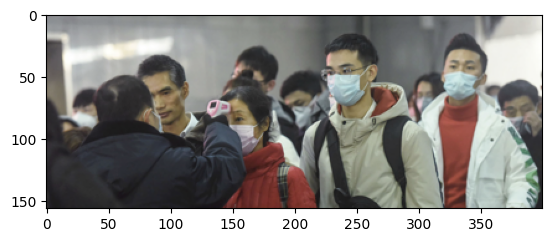

In [52]:
image = load_img('8_data/images/maksssksksss1.png')
image = img_to_array(image) # default: dtype is float32
h, w = image.shape[:2]

plt.imshow(image/255.) # because the type is float we have to normalize it in between [0, 1]

In [53]:
# BeautifulSoup is one of the most used libraries when it comes to web scraping with Python. 
# Since XML files are similar to HTML files, it is also capable of parsing them. 
# To parse XML files using BeautifulSoup though, it’s best that you make use of Python’s lxml parser.

from bs4 import BeautifulSoup 

In [54]:
def generate_box(obj):

    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

In [55]:
# function to capture the face based on bouding box - which is stored in 'annotation.xml' files
def crop_face(filename, dir): 
    label_file = dir + '/annotations/' + filename + '.xml'
    image_file = dir + '/images/' + filename + '.png'

    image = load_img(image_file)  # Load file into PIL format -> can show image with 
    image = img_to_array(image) # Load PIL format to numpy array
                              # default: dtype is float32  

    h, w = image.shape[:2]

    with open(label_file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        # each object is a set of features of a face in the image
        objects = soup.find_all('object')

        num_objs = len(objects)

        # loop for each bounding box of a face in the image
        for n, i in enumerate(objects):
            [xmin, ymin, xmax, ymax] = generate_box(i)

            (xmin,ymin) = (max(0,xmin), max(0,ymin))
            (xmax,ymax) = (min(w-1,xmax), min(h-1,ymax))

            face = image[ymin:ymax, xmin:xmax]

            label = generate_label(i)
            if label == 0:
                target_path = dir + '/without_mask/' + filename + '_face_' + str(n)
            elif label == 1:
                target_path = dir + '/with_mask/' + filename + '_face_' + str(n)

            # If we don't use "else: break" here (when label == 2), the 'target_path' variable will be not assign to any value 
            # and we will see this error: 
            # ---> 37       im.save(target_path + '.png')
            #     38 

            # UnboundLocalError: local variable 'target_path' referenced before assignment
            else:
                break 

            im = Image.fromarray(face.astype(np.uint8)) # fromarray() only work with dtype = np.uint8
                                                      # https://stackoverflow.com/questions/55319949/pil-typeerror-cannot-handle-this-data-type
            im.save(target_path + '.png')



Now we will extract the faces of all images

In [56]:
files = os.listdir('8_data/images')

for file in files:
    filename = file.split('.')[0]
    crop_face(filename, dir='8_data')


Let's see if we crop and put the faces in the right folders

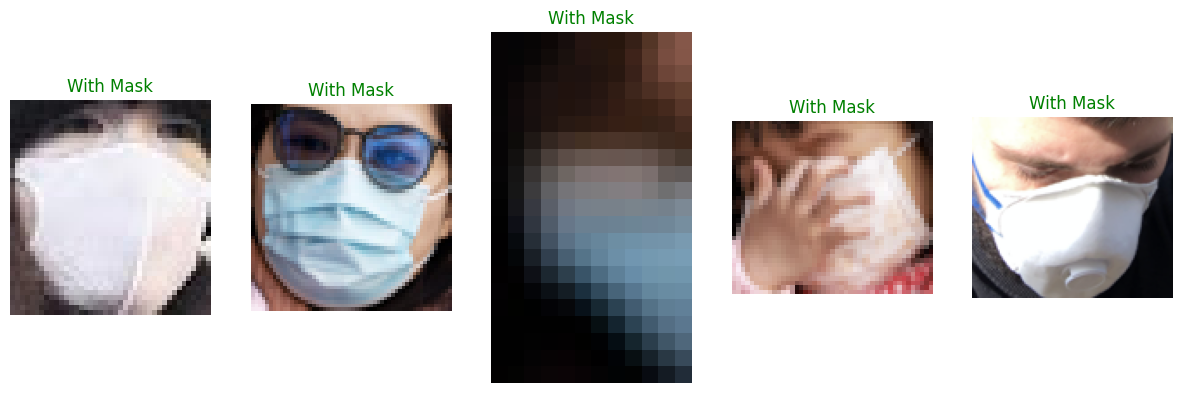

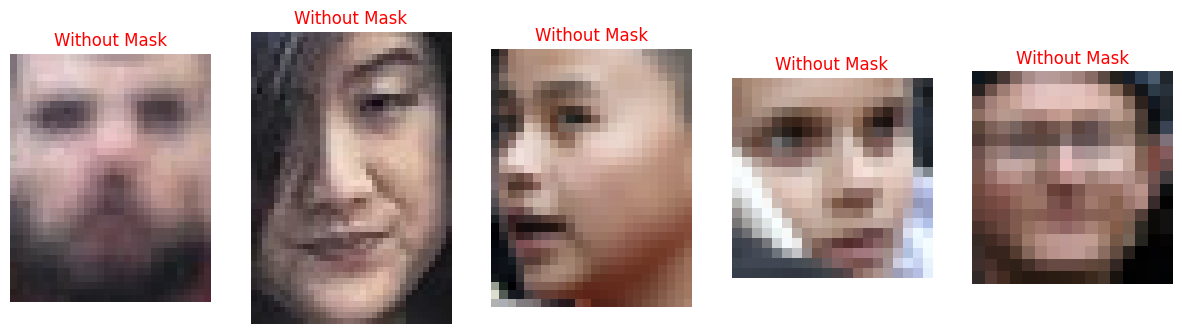

In [57]:
plt.figure(figsize=(15,15))

with_mask_images = os.listdir('8_data/with_mask')[:5] # Just get 5 images

for i, image in enumerate(with_mask_images):
    images_path = '8_data/with_mask/' + image
    img = Image.open(images_path)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title('With Mask', color='g')
    plt.axis(False)

plt.figure(figsize=(15,15))

without_mask_images = os.listdir('8_data/without_mask')[:5] # Just get 5 images

for i, image in enumerate(without_mask_images):
    images_path = '8_data/without_mask/' + image
    img = Image.open(images_path)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title('Without Mask', color='r')
    plt.axis(False)

In [58]:
walk_through_dir('8_data')

There are 4 directories and 0 images in '8_data'.
There are 0 directories and 853 images in '8_data\annotations'.
There are 0 directories and 853 images in '8_data\images'.
There are 0 directories and 613 images in '8_data\without_mask'.
There are 0 directories and 2850 images in '8_data\with_mask'.


In [ ]:
# Copy to `dataset` folder
!copy "8_data\with_mask"\* "dataset\with mask"
!copy "8_data\without_mask"\* "dataset\without mask"

In [60]:
walk_through_dir('dataset')

There are 2 directories and 0 images in 'dataset'.
There are 0 directories and 15818 images in 'dataset\with mask'.
There are 0 directories and 11414 images in 'dataset\without mask'.


Now we will see some images from `with mask` folder and `without mask` folder from `dataset`

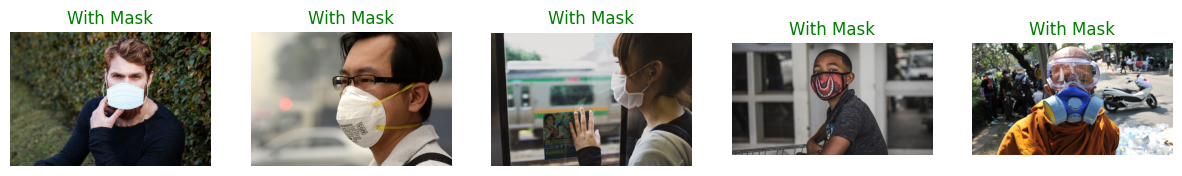

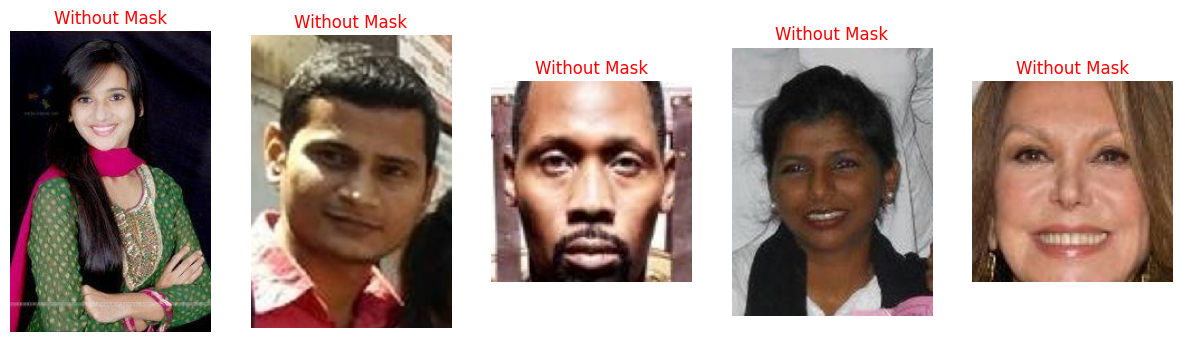

In [61]:
with_mask_images = os.listdir('dataset/with mask')[:5] # Just get 5 images

plt.figure(figsize=(15,15))

for i, image in enumerate(with_mask_images):
    images_path = 'dataset/with mask/' + image
    img = Image.open(images_path)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title('With Mask', color='g')
    plt.axis(False)

plt.figure(figsize=(15,15))

without_mask_images = os.listdir('dataset/without mask')[:5] # Just get 5 images

for i, image in enumerate(without_mask_images):
    images_path = 'dataset/without mask/' + image
    img = Image.open(images_path)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title('Without Mask', color='r')
    plt.axis(False)

# 3. Tiền xử lý dữ liệu

- Sau khi đã tạo ra một tập dữ liệu hoàn chỉnh, bạn sẽ tiến hành biến dữ liệu thành dạng mà máy tính có thể xử lý được như đã làm trong các bài học. Cụ thể bạn sẽ:

- Khởi tạo ra đường dẫn của từng tấm ảnh trong tập dữ liệu

In [62]:
# Đường dẫn đến thư mục 'dataset'
dataset = 'dataset'

imagePaths = list(paths.list_images(dataset))  

In [63]:
imagePaths[0]

'dataset\\with mask\\0-with-mask.jpg'

<details><summary> Gợi ý </summary>

Sử dụng biến ```dataset```

</details>

- Mặc dùng tập dữ liệu của chúng ta có thể sẽ có hơn 15 nghìn bức ảnh, tuy nhiên chúng ta sẽ chỉ sử dụng 8000 bức ảnh để huấn luyện và kiểm tra mô hình. Các tấm ảnh còn lại sẽ được sử dụng cho mục đích cải thiện chất lượng của mô hình (nếu có)

In [64]:
# khởi tạo list rỗng: chứa các bức ảnh
data = []

# khởi tạo list rỗng: chứa các nhãn của bức ảnh 
# (cũng chính là tiêu đề của thư mục chứa các bức ảnh: with/without mask)
labels = []

# Chỉ sử dụng 4000 bức ảnh đầu tiên và 4000 bước ảnh cuối cùng tương ứng với đường dẫn imagePaths

for i in imagePaths[-4000:] + imagePaths[:4000]:
    
    label = i.split(os.sep)[-2] # os.sep: The character used by the operating system to separate pathname components. 
                                # This is '/' for POSIX and '\\' for Windows.
        
    # Chèn các dữ liệu nhãn vào list labels
    labels.append(label)
    
    # Sử dụng hàm load_img để tạo mảng chứa dữ liệu tấm ảnh với kích thước 224 x 224
    image = load_img(i, target_size = (224, 224))  # Load file into PIL format -> can show image with 
    image = img_to_array(image) # Load PIL format to numpy array
    # Chèn các dữ liệu ảnh vào list data
    data.append(image)
    
# mã hóa list dữ liệu thành định dạng mảng NumPy    
data = np.array(data,dtype='float32')
labels = np.array(labels)

<details><summary> Gợi ý </summary>

[load_img()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/load_img)

[img_to_array()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/img_to_array)

</details>

In [65]:
# In ra định dạng của tập dữ liệu data
data.shape

(8000, 224, 224, 3)

- Mặc dù chúng ta đã có dữ liệu và nhãn của chúng, tuy nhiên chúng ta  cần phải thực hiện thêm một bước nữa để mô hình có thể nhận diện nhãn của các mô hình, đó là mã hóa nhãn của dữ liệu bằng Mã hóa Nhị Phân (Binary Encoding, do chúng ta chỉ có 2 nhãn) 

In [66]:
# Sử dụng LabelBinarizer để mã hóa mảng labels

# Mã hóa nhị phân cho 2 loại nhãn
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# Chuyển từng nhãn sau khi đã mã hóa thành từng vector nhị phân tương ứng
labels = to_categorical(labels) # to_categorical convert integer vector into binary matrix

*We can using `OneHotEncoder` instead*

In [67]:
# tmp = np.concatenate((labels[-10:], labels[:10])).reshape(-1,1)

# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(categories='auto',
#                         sparse_output=False,
#                         handle_unknown='error') # giúp xử lý nhãn hiếm

# encoder.fit_transform(tmp).astype('float32')

<details><summary> Gợi ý </summary>

Sử dụng ```LabelBinarizer()``` để mã hóa nhị phân

Sử dụng ```to_categorical()``` để tạo vector nhị phân

</details>

- Chia tập dữ liệu thành 3 tập là **train/validation/test** với tỉ lệ **5/1/4**. Tuy nhiên cần phải lưu ý cân bằng số lượng nhãn trong mỗi tập dữ liệu train/validation/test, điều này sẽ được thể hiện trong tham số **stratify** của hàm **train_test_split**. Đặt tham số **random_state = 0** cho việc phân chia dữ liệu

In [68]:
data.shape, labels.shape

((8000, 224, 224, 3), (8000, 2))

In [69]:
train_X, test_X, train_Y, test_Y = train_test_split(data, labels, test_size = 0.5, stratify = labels, random_state = 0)
val_X, test_X, val_Y, test_Y = train_test_split(test_X, test_Y, test_size = 0.8, stratify = test_Y, random_state = 0)

<details><summary> Gợi ý </summary>

Sử dụng ```train_test_split()``` để chia tập dữ liệu

[train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

</details>

In [70]:
train_X.shape

(4000, 224, 224, 3)

In [71]:
train_X.shape

(4000, 224, 224, 3)

In [72]:
train_Y.shape

(4000, 2)

In [73]:
test_X.shape

(3200, 224, 224, 3)

In [74]:
test_Y.shape

(3200, 2)

# 4. Khởi tạo và huấn luyện mô hình

khởi tạo hàm tăng cường dữ liệu (Data Augmentation) bằng **ImageDataGenerator** với các tham số sau:

- rotation_range = 20
- zoom_range = 0.15
- width_shift_range = 0.2
- height_shift_range=0.2
- shear_range = 0.15
- horizontal_flip = True
- vertical_flip = True
- fill_mode = 'nearest'

In [75]:
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='nearest')

<details><summary> Gợi ý </summary>

[ImageDataGenerator()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

</details>

## 4.1 Khởi tạo mô hình

Chúng ta sẽ sử dụng EfficientNet là mô hình cơ sở và kết hợp với một vài lớp mạng neuron sau đó để tạo thành một mô hình nhận diện khẩu trang hoàn chỉnh. Cấu trúc từng lớp theo thứ tự của mạng neuron của chúng ta như sau:

1. Lớp đầu tiên: mô hình **EfficientNetB0** với các tham số:

    - weights = 'imagenet'
    
    - include_top = False
    
    - input_tensor = Input(shape = (224, 224, 3))
    
    
2. **AveragePooling2D** với các tham số mặc định


3. **Flatten**

    - name = 'Flatten'


4. **Dense**

    - units = 128
    
    - activation = 'relu'
    
    
5. **Dropout**

    - rate = 0.5


6. **Dense**

    - units = 2
    
    - activation = 'softmax'

- Khởi tạo lớp đầu tiên (mạng cơ sở)

In [76]:
baseModel = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=Input(shape=(224,224,3)))

baseModel.trainable = False

<details><summary> Gợi ý </summary>

Khởi tạo lớp ```EfficientNetB0``` với các thông số đã nêu ở trên

</details>

In [77]:
baseModel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

- Khởi tạo các lớp kế tiếp theo thứ tự đã kể ở trên

In [78]:
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(name='Flatten')(headModel)
headModel = Dense(units=128, activation='relu')(headModel)
headModel = Dropout(rate=0.5)(headModel)
headModel = Dense(units=2, activation='softmax')(headModel)

model = Model(inputs = baseModel.input, outputs = headModel)

<details><summary> Gợi ý </summary>

Khởi tạo từng lớp mạng neuron liền kề với thứ tự sau:

AveragePooling2D -> Flatten -> Dense -> Dropout -> Dense

</details>

- Chúng ta sẽ không huấn luyện các trọng số trong các lớp của mạng EfficientNet 

In [79]:
# for layer in baseModel.layers:
#     layer.trainable = False

# Không cần vì ta đã có baseModel.trainable = False ở phía trên
trainable_layer = 0
for layer in baseModel.layers:
    if layer.trainable == True:
        trainable_layer += 1
        
if trainable_layer == 0:
    print('All of layers are Untrainable')
else:
    print('Some of layers are Trainable')

All of layers are Untrainable


<details><summary> Gợi ý </summary>

layer.trainable = False

</details>

In [80]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

**Option**: Có thể kết hợp lại để hàm `model.summary` ngắn gọn hơn

In [147]:
# baseModel = EfficientNetB0(include_top=False, weights='imagenet')
# baseModel.trainable = False

# inputs = Input(shape=(224, 224, 3), name="input_layer")

# x = baseModel(inputs)
# x = AveragePooling2D()(x)
# x = Flatten(name='Flatten')(x)
# x = Dense(units=128, activation='relu')(x)
# x = Dropout(rate=0.5)(x)
# outputs = Dense(units=2, activation='softmax')(x)

# model = Model(inputs, outputs)

# model.summary()

## 4.2 Huấn luyện mô hình

Tiến hành huấn luyện mô hình với các điều sau:

- Thuật toán tối ưu là **Adam Optimization** với các tham số:
    
    - learning_rate = learning_rate
    
    - decay = learning_rate/Epochs
    
- Hàm Loss là **Binary Crossentropy**

- Metric là chỉ số **ROC-AUC**

In [81]:
learning_rate = 0.001
Epochs = 10
BS = 40

# Khởi tạo thuật toán tối ưu Adam
opt = Adam()
model.compile(loss='binary_crossentropy', optimizer = opt, metrics = ['AUC'])

H = model.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X, train_Y, batch_size = BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs
)

# lưu mô hình lại để tiện cho việc tái sử dụng sau này, lưu trữ dưới tên 'efficientnet.model'
model.save('efficientnet.model')

Epoch 1/10
100/100 [==============================] - 80s 679ms/step - loss: 0.1433 - auc: 0.9836 - val_loss: 0.0640 - val_auc: 0.9930
Epoch 2/10
100/100 [==============================] - 56s 560ms/step - loss: 0.0609 - auc: 0.9947 - val_loss: 0.0395 - val_auc: 0.9960
Epoch 3/10
100/100 [==============================] - 52s 518ms/step - loss: 0.0724 - auc: 0.9938 - val_loss: 0.0300 - val_auc: 0.9961
Epoch 4/10
100/100 [==============================] - 51s 512ms/step - loss: 0.0601 - auc: 0.9946 - val_loss: 0.0339 - val_auc: 0.9971
Epoch 5/10
100/100 [==============================] - 53s 528ms/step - loss: 0.0443 - auc: 0.9964 - val_loss: 0.0387 - val_auc: 0.9948
Epoch 6/10
100/100 [==============================] - 50s 499ms/step - loss: 0.0477 - auc: 0.9959 - val_loss: 0.0393 - val_auc: 0.9948
Epoch 7/10
100/100 [==============================] - 48s 482ms/step - loss: 0.0437 - auc: 0.9950 - val_loss: 0.0371 - val_auc: 0.9960
Epoch 8/10
100/100 [==============================] - 5

D:\Anaconda\envs\env_1\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


- In ra lịch sử huấn luyện của mô hình

In [82]:
H.history

{'loss': [0.14331132173538208,
  0.06086212769150734,
  0.07236585021018982,
  0.06008032709360123,
  0.04433037340641022,
  0.04766146466135979,
  0.04373043775558472,
  0.04773160442709923,
  0.03956985101103783,
  0.03653664141893387],
 'auc': [0.9836467504501343,
  0.9946550130844116,
  0.9937611222267151,
  0.994615375995636,
  0.9964063763618469,
  0.9958957433700562,
  0.9949632287025452,
  0.9948951005935669,
  0.9952026009559631,
  0.9964326024055481],
 'val_loss': [0.06401479244232178,
  0.03947027400135994,
  0.030012868344783783,
  0.033873043954372406,
  0.03868795931339264,
  0.03934692218899727,
  0.03707018122076988,
  0.03271060809493065,
  0.03236578404903412,
  0.04787149280309677],
 'val_auc': [0.9929577708244324,
  0.9959530234336853,
  0.9960749745368958,
  0.9971234202384949,
  0.9947608709335327,
  0.9948000907897949,
  0.996025025844574,
  0.9960124492645264,
  0.9960796236991882,
  0.9945577383041382]}

- Vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

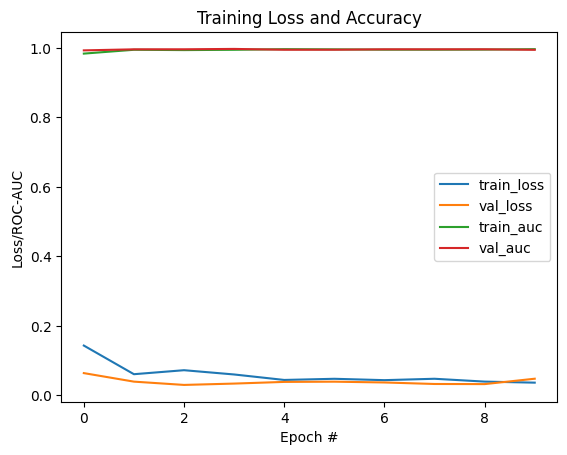

In [83]:
# vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

N = Epochs
# plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["auc"], label="train_auc")
plt.plot(np.arange(0, N), H.history["val_auc"], label="val_auc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/ROC-AUC")
plt.legend(loc="center right")

# 5. Kiểm tra mô hình

Nhắc lại, quá trình nhận diện một gương mặt có đeo khẩu trang hay không được thực hiện theo từng bước sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trang hoặc không (3) --> Gán nhãn tương ứng (4)**

Trong phần này chúng ta sẽ thực hiện việc kiểm tra mô hình nhận diện đeo khẩu trang. Về phần nhận diện gương mặt chúng ta sẽ sử dụng mô hình MTCNN với các hàm và thư viện mà chúng ta đã cung cấp sẵn

- Import các thư viện cần thiết cho việc kiểm tra

In [85]:
import cv2
from align_faces import warp_and_crop_face, get_reference_facial_points
from mtcnn.detector import MtcnnDetector
from tensorflow.keras.models import load_model

- Sử dụng hàm nhận diện gương mặt có sẵn đã được cung cấp để tiến hành Face Detection và Face Alignment trước khi nhận diện khẩu trang.

**Lưu ý**: Hàm này có thể không hoạt động được và trả về lỗi nếu trong bức ảnh không có gương mặt nào hoặc trong một vài trường hợp không thể nhận diện được **ảnh trong gương mặt** (???)

**Có thể chúng ta sẽ thắc mắc tại sao chúng ta phải sử dụng Face Alignment?**

Đúng như tên gọi của nó: Alignment (sự căn chỉnh), Face Alignment giúp khuôn mặt dù có bị quay ngang, bị chéo mặt hay thậm chị bị mất nhiều chi tiết do điều kiện ngoại cảnh, lệch ra khỏi khung hình... cũng có thể "căn chỉnh" lại về trung tâm bức ảnh với hướng mặt thẳng chính giữa như mong muốn được. Sau bước detection thì các khuôn mặt của chúng ta có thể ở các trạng thái khác nhau hoặc các góc độ khác nhau, có những khuôn mặt bị chéo và cũng có thể bị lệch do bước detect chưa chính xác trong việc lấy ra khung hình chuẩn của mặt. Thì việc áp dụng Face Alignment ở đây là cần thiết, nó có thể hiểu như một hình thức của data normalization (chuẩn hóa dữ liệu), giúp tiêu chuẩn hoá lại dữ liệu trước khi đưa vào mô hình phân loại (binary classcification), điều này giúp cho mô hình có kết quả dự đoán chính xác hơn. Chúng ta có thể so sánh với **mô hình chỉ có Face Detection mà không có Face Alignment** với mô hình ở phía dưới để so sánh kết quả xem liệu sự có mặt của Face Alignment liệu thật sự có cải thiện kết quả hay không.

In [86]:
detector = MtcnnDetector()

def face_detection(img, output_size, align = False):
    """Nếu align == True thì sẽ có thêm bước Face Alignment sau khi nhận diện gương mặt,
        ngược lại thì không có thêm bước này"""
    
    # Nhận diện gương mặt
    boxes, facial5points = detector.detect_faces(img)
    
    # Tiến hành Alignment
    if align == True:
        if len(facial5points) != 0:
            facial5points = np.reshape(facial5points[0], (2, 5))

            default_square = True
            inner_padding_factor = 0.25
            outer_padding = (0, 0)

            # sử dụng hàm get_reference_facial_points
            reference_5pts = get_reference_facial_points(
                output_size, inner_padding_factor, outer_padding, default_square)
            
            # sử dụng hàm warp_and_crop_face
            face = warp_and_crop_face(img, facial5points, reference_pts = reference_5pts, crop_size = output_size)
               
    # Không Alignment
    else:
        (h,w) = img.shape[:2]
        if len(boxes) != 0:
            for box in boxes:
                (startX, startY, endX, endY) = box[:4].astype('int')
                (startX, startY) = (max(0, startX),max(0, startY))
                (endX, endY) = (min(w-1, endX), min(h-1, endY))
                face = img[startY:endY, startX:endX]
                face = cv2.resize(face, output_size)
                
    return face

- Tạo ra mảng chứa các ảnh sau đã thực hiện việc nhận diện gương mặt

In [87]:
test_X_align = test_X.copy()

- Như đã lưu ý ở trên, có thể có một vài bức ảnh không thể nhận diện gương mặt được với hàm này, cho nên chúng ta sẽ chỉ lựa chọn ra các bức ảnh chỉ nhận diện được và lưu chỉ mục của chúng vào mảng **choose**. Sử dụng cấu trúc **try-except** để xử lý lỗi trong trường hợp này

In [88]:
choose = []

for i in range(len(test_X)):
    try:
        # Tiến hành nhận diện gương mặt kết hợp với Face Alignement, trả về kích thươc ảnh là 224x224
        test_X_align[i] = face_detection(test_X[i].astype('uint8'), (224, 224), align = True)
        # Lưu chỉ mục của ảnh đã nhận diện thành công vào mảng choose
        choose.append(i)
    except:
        # Nếu tấm ảnh không nhận diện được thì chúng ta sẽ bỏ qua tấm này
        continue
        
choose = np.array(choose)

In [89]:
test_X_align.shape

(3200, 224, 224, 3)

In [90]:
test_X_align[choose, :, :, :].shape

(1753, 224, 224, 3)

- Chúng ta sẽ sử dụng chỉ số **ROC-AUC** làm chỉ số đánh giá mô hình

In [91]:
from sklearn.metrics import roc_auc_score

- Lọc ra các tấm ảnh với mảng choose và tiến hành tính chỉ số ROC-AUC

In [92]:
predict = model.predict(test_X_align[choose])
predict = np.argmax(predict, axis=1)
roc_auc_score(test_Y[choose].argmax(axis=1), predict)

0.976902227745061

## 5.1 Multi-faces

Nếu ở phần trên chúng ta chỉ nhận diện tấm ảnh chỉ có một gương mặt duy nhất thì ở phần này chúng ta sẽ nhận diện nhiều gương mặt có đeo khẩu trang hay không trong cùng một bức ảnh với mô hình ở trên

- Sử dụng hàm có sẵn

In [93]:
def mask_detect(image):
    
    img = image.copy()
    (h,w) = img.shape[:2]
    boxes, facial5points = detector.detect_faces(img)
    for box in boxes:
        (startX,startY,endX,endY)=box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=img[startY:endY, startX:endX]
        face=cv2.resize(face,(224,224))
        
        
        
        (mask,withoutMask)=model.predict(face.reshape(1,224,224,3))[0]  #because the result of predict() method is always a 2D numpy array
                                                                    #so we need to get the first element (although there is just only 1 elemnent :) 
                                                                        
                                                                        

        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)

        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(img,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(img,(startX,startY),(endX,endY),color,2)
        
    return img

- Nhận diện một vài bức ảnh có sẵn trong thư mục image

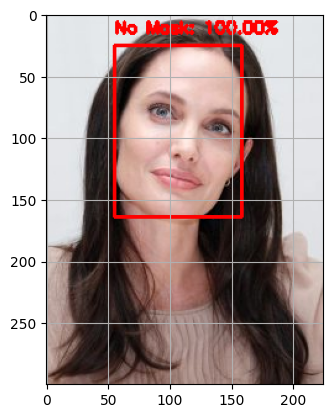

In [94]:
img = cv2.imread("image/angelina.jpg")
img = mask_detect(img)

plt.imshow(img[:, :, ::-1]) # change to RGB ordered values
plt.grid(None) # create a grid for the image

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

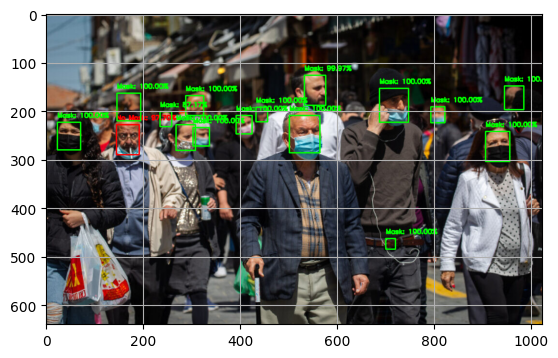

In [95]:
img = cv2.imread("image/people.jpg")
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

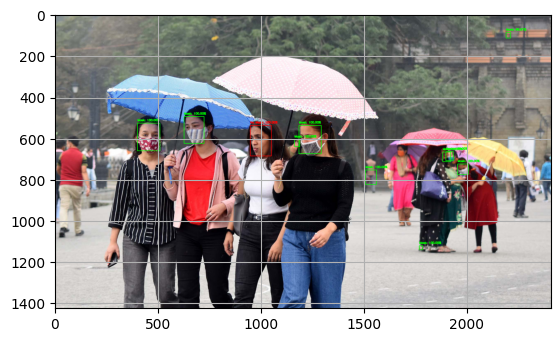

In [96]:
img = cv2.imread("image/woman.jpg")

img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

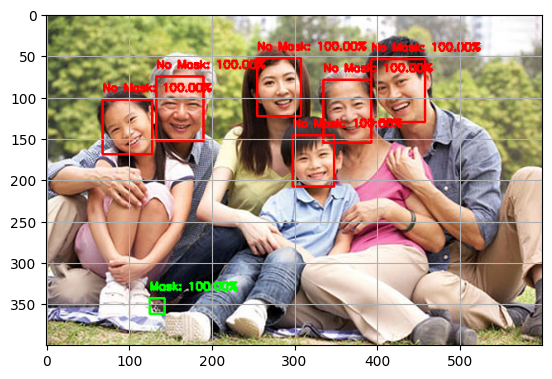

In [97]:
img = cv2.imread("image/family.jpg")

img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 5.2 Video

Ở phần này chúng ta sẽ nhận diện gương mặt đeo khẩu trang theo thời gian thực thông qua camera của máy tính

In [98]:
from imutils.video import VideoStream
import imutils

In [100]:
vs = cv2.VideoCapture(0)

while True:
    #grab the frame from the threaded video stream and resize it
    #to have a maximum width of 400 pixels
    frame = vs.read()[1]
    (h, w) = frame.shape[:2]
    boxes, facial5points = detector.detect_faces(frame)
    for box in boxes:
        (startX, startY, endX, endY) = box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX, startY) = (max(0, startX),max(0, startY))
        (endX, endY) = (min(w-1, endX), min(h-1, endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face = frame[startY:endY, startX:endX]
        face = cv2.resize(face,(224,224))

        (mask, withoutMask) = model.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label = 'Mask' if mask > withoutMask else 'No Mask'
        color = (0, 255, 0) if label == 'Mask' else (0, 0, 255)

        #include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(frame, label, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
        
    #show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('q'):
        break
        
cv2.destroyAllWindows()

# 6. Cải thiện mô hình

- Phần này chúng ta sẽ tự đề xuất và thực thi các phương pháp khác nhau nhằm mục đích cải thiện chất lượng mô hình tốt hơn có thể có. Tức là chỉ số **ROC-AUC >= 0.992**. Một số phương pháp được đề xuất như sau:

1. Cải thiện model nhận diện đeo khẩu trang.

2. Cải thiện model phát hiện khuôn mặt.

3. Sử dụng thêm dữ liệu cho quá trình huấn luyện.

4. Cải thiện phần face alignment